# Goals

Understanding why and when employees are most likely to leave. Data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn.

In [1]:
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns

PATH = Path('data')

In [4]:
from itertools import product

In [5]:
def date_breakdown(df,col):
    df[f'{col}_year']=df[col].dt.year
    df[f'{col}_month']=df[col].dt.month
    df[f'{col}_day']=df[col].dt.day
    df[f'{col}_dayofweek']=df[col].dt.dayofweek
    return df
def get_data():
    df= pd.read_csv(PATH/'employee_retention_data.csv',parse_dates=['join_date', 'quit_date'])
    for col in ['join_date','quit_date']:
        df = date_breakdown(df,col)
    df['quit'] = ~df.quit_date.isnull()
    df['employed_delta'] = (df.quit_date - df.join_date) / np.timedelta64(1, 'M')
    df.drop(df[df.seniority>=90].index,inplace=True)
    df = df.sort_values('join_date').reset_index(drop=True)
    return df
def get_headcount():
    df = get_data()
    
    dates=pd.date_range('2011-01-24','2015-12-23').values
    companies=sorted(df.company_id.unique())
    
    df_headcount=pd.DataFrame(list(product(*[dates,companies])),columns=['date','company_id'])
    df_headcount.date = pd.to_datetime(df_headcount.date)
    df_join=df.groupby(['join_date','company_id']).size().reset_index(name='join_count')
    df_quit = df.groupby(['quit_date','company_id']).size().reset_index(name='quit_count')
    df_headcount = df_headcount.merge(df_join,how='left',
                                      left_on=['date','company_id'],
                                      right_on=['join_date','company_id'])
    df_headcount = df_headcount.merge(df_quit,how='left',
                                      left_on=['date','company_id'],
                                      right_on=['quit_date','company_id'])
    df_headcount.drop(['join_date','quit_date'],axis=1,inplace=True)
    df_headcount.fillna(0,inplace=True)
    
    df_headcount['headcount'] = df_headcount.groupby('company_id').join_count.cumsum() \
                                    - df_headcount.groupby('company_id').quit_count.cumsum()
    for col in df_headcount.columns.values[-3:]:
        df_headcount[col] = df_headcount[col].astype(np.int32)
    df_headcount = date_breakdown(df_headcount,'date')
    return df_headcount

In [6]:
df = get_data()

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13. That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.
What are the main factors that drive employee churn? Do they make sense? Explain your findings.
If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [7]:
df.head()
df.shape

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,join_date_year,join_date_month,join_date_day,join_date_dayofweek,quit_date_year,quit_date_month,quit_date_day,quit_date_dayofweek,quit,employed_delta
0,679816.0,3,engineer,18,243000.0,2011-01-24,2015-08-07,2011,1,24,0,2015.0,8.0,7.0,4.0,True,54.407688
1,280323.0,1,data_science,1,74000.0,2011-01-24,2012-08-31,2011,1,24,0,2012.0,8.0,31.0,4.0,True,19.220107
2,554358.0,1,customer_service,8,67000.0,2011-01-24,2013-03-01,2011,1,24,0,2013.0,3.0,1.0,4.0,True,25.199696
3,527591.0,2,engineer,11,178000.0,2011-01-24,2011-12-16,2011,1,24,0,2011.0,12.0,16.0,4.0,True,10.710692
4,897062.0,3,engineer,17,240000.0,2011-01-24,2012-02-10,2011,1,24,0,2012.0,2.0,10.0,4.0,True,12.550566


(24700, 17)

In [8]:
df.join_date.describe()
df.quit_date.describe()

count                   24700
unique                    995
top       2012-01-03 00:00:00
freq                      105
first     2011-01-24 00:00:00
last      2015-12-10 00:00:00
Name: join_date, dtype: object

count                   13508
unique                    664
top       2015-05-08 00:00:00
freq                      111
first     2011-10-13 00:00:00
last      2015-12-09 00:00:00
Name: quit_date, dtype: object

# Headcount table

In [10]:
df_headcount = get_headcount()

In [11]:
df_headcount[df_headcount.date_year==2014].sort_values(['company_id','date']).head(10)

,date,company_id,join_count,quit_count,headcount,date_year,date_month,date_day,date_dayofweek
12876,2014-01-01,1,0,0,3481,2014,1,1,2
12888,2014-01-02,1,2,1,3482,2014,1,2,3
12900,2014-01-03,1,0,30,3452,2014,1,3,4
12912,2014-01-04,1,0,0,3452,2014,1,4,5
12924,2014-01-05,1,0,0,3452,2014,1,5,6
12936,2014-01-06,1,33,2,3483,2014,1,6,0
12948,2014-01-07,1,4,1,3486,2014,1,7,1
12960,2014-01-08,1,2,1,3487,2014,1,8,2
12972,2014-01-09,1,2,0,3489,2014,1,9,3
12984,2014-01-10,1,0,27,3462,2014,1,10,4


# EDA

In [13]:
df = get_data()
df.shape

(24700, 17)

In [35]:
# df['quit'] = ~df.quit_date.isnull()

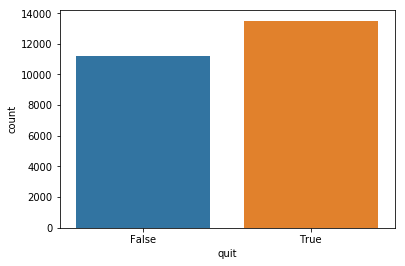

In [14]:
sns.countplot(x='quit',data=df)
# in the span of 5 years, more than half of employed people quit

In [15]:
df.isnull().sum()

employee_id                0
company_id                 0
dept                       0
seniority                  0
salary                     0
join_date                  0
quit_date              11192
join_date_year             0
join_date_month            0
join_date_day              0
join_date_dayofweek        0
quit_date_year         11192
quit_date_month        11192
quit_date_day          11192
quit_date_dayofweek    11192
quit                       0
employed_delta         11192
dtype: int64

In [16]:
df.employee_id.nunique() == df.shape[0]
# Employee ID is unique. However this doesn't mean that there is only one record per person. 
# When someone switches company, he/she will have a different employee ID

True

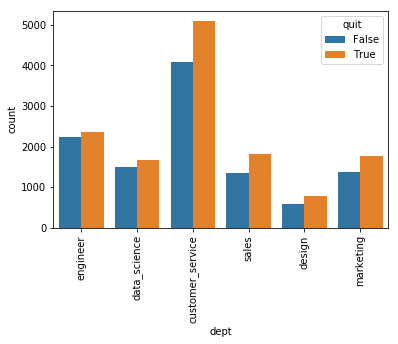

In [17]:
ax=sns.countplot(x='dept',hue='quit',data=df)
_=plt.setp(ax.get_xticklabels(),rotation=90)

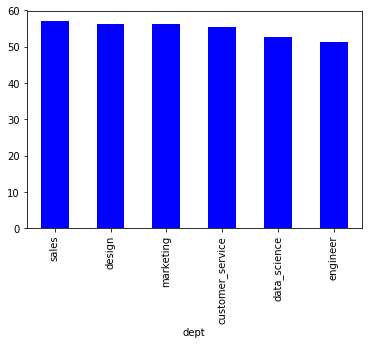

In [18]:
# turnover rate for each department
(df.groupby('dept').quit.mean().sort_values(ascending=False) * 100).plot(kind='bar',color='blue')

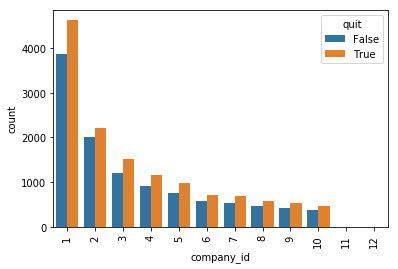

In [19]:
ax=sns.countplot(x='company_id',hue='quit',data=df)
_=plt.setp(ax.get_xticklabels(),rotation=90)


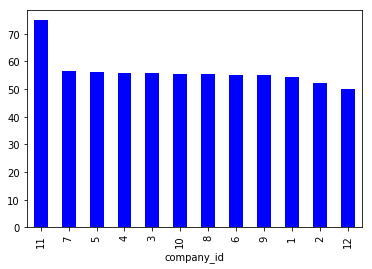

In [20]:
# turnover rate for each company
(df.groupby('company_id').quit.mean().sort_values(ascending=False) * 100).plot(kind='bar',color='blue')

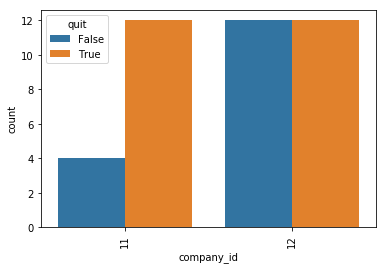

In [21]:
ax=sns.countplot(x='company_id',hue='quit',data=df[df.company_id.isin([11,12])])
_=plt.setp(ax.get_xticklabels(),rotation=90)
#company 11 has it worst. company 12 is perfectly balance

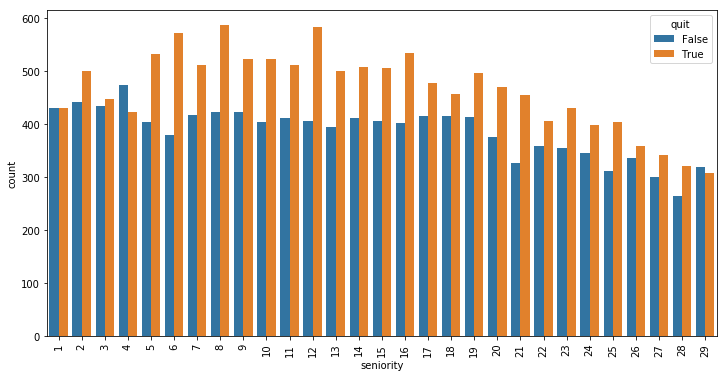

In [22]:
fig,ax = plt.subplots(figsize=(12,6))
sns.countplot(x='seniority',hue='quit',data=df,ax=ax)
_=plt.setp(ax.get_xticklabels(),rotation=90)


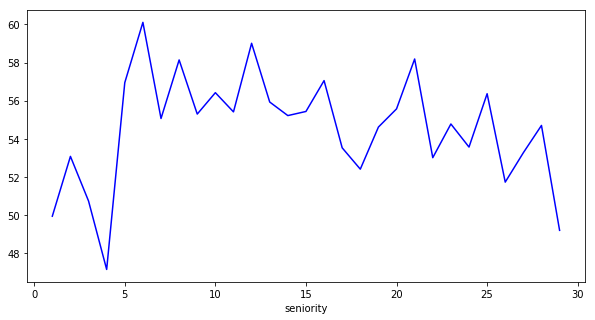

In [25]:
fig,ax = plt.subplots(figsize=(10,5))
(df.groupby('seniority').quit.mean()*100).plot(color='blue')

Sudden peak in turnover rate for seniority between 5 and 15. TODO: confirm with data provider how and when seniority is recorded (Is it deteremined when they are employed or after termination, if the latter then we have a leak)

In [26]:
df.salary.nunique()

367

In [27]:
df.salary.describe()

count     24700.000000
mean     138176.275304
std       76056.331953
min       17000.000000
25%       79000.000000
50%      123000.000000
75%      187000.000000
max      408000.000000
Name: salary, dtype: float64

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


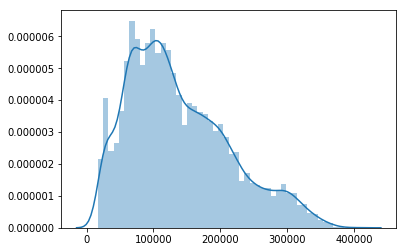

In [28]:
sns.distplot(df.salary.values,kde=True)

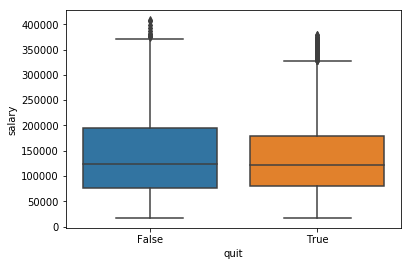

In [29]:
sns.boxplot(x='quit',y='salary',data=df)

Normal distribution. For employee with high salary (> 200000), there are higher chance for them to stay.

# Timeseries EDA

In [30]:
df.join_date.describe()
df.quit_date.describe()

count                   24700
unique                    995
top       2012-01-03 00:00:00
freq                      105
first     2011-01-24 00:00:00
last      2015-12-10 00:00:00
Name: join_date, dtype: object

count                   13508
unique                    664
top       2015-05-08 00:00:00
freq                      111
first     2011-10-13 00:00:00
last      2015-12-09 00:00:00
Name: quit_date, dtype: object

In [31]:
df.employed_delta.describe()

count    13508.000000
mean        20.154190
std         10.796464
min          3.351198
25%         11.860613
50%         13.700487
75%         25.659664
max         56.707530
Name: employed_delta, dtype: float64

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'month')

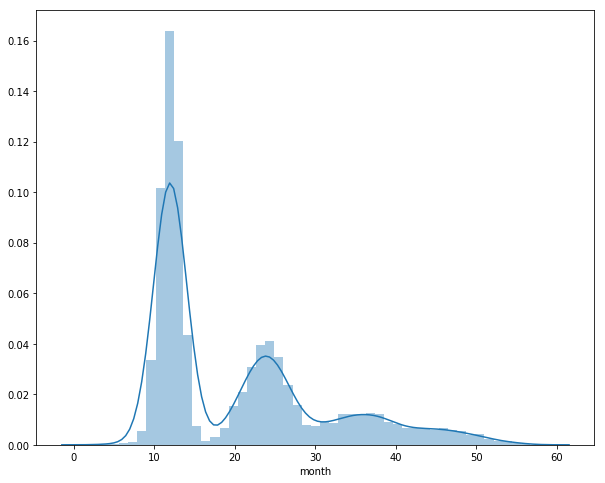

In [32]:
fig,ax = plt.subplots(figsize=(10,8))
sns.distplot(df.loc[df.quit,'employed_delta'].values,kde=True)
ax.set_xlabel('month')

In [33]:
# identify three modes of this population
delta = df.loc[df.quit,'employed_delta']
delta[delta.between(6,16)].describe()
delta[delta.between(16,30)].describe()
delta[delta.between(30,41)].describe()
delta[delta>=41].describe()

count    7320.000000
mean       11.943379
std         1.313414
min         6.012444
25%        11.137806
50%        11.959178
75%        12.780550
max        15.934619
Name: employed_delta, dtype: float64

count    3755.000000
mean       23.801933
std         2.658113
min        16.000329
25%        21.979917
50%        23.819791
75%        25.659664
max        29.996509
Name: employed_delta, dtype: float64

count    1553.000000
mean       35.535233
std         2.947257
min        30.029364
25%        33.249143
50%        35.548985
75%        37.848826
max        40.838621
Name: employed_delta, dtype: float64

count    866.000000
mean      46.402971
std        3.570922
min       41.002895
25%       43.475225
50%       45.898273
75%       48.888068
max       56.707530
Name: employed_delta, dtype: float64

This is a multimodal distribution with 2 clear modes and 1 hidden mode. All these 3 modes are happen to be near 12,24 and 36 month mark (1,2,3 years) in which the 12-month mark has the highest frequency. This indicates that most employee quit after a year working with their company. It's interesting that these peaks are near the exact 1-year (or 2,3-year) mark. This could possibly mean that some events happen around these marks that affect their employment (performance review perhaps)

## analysis on hire date vs quit date

Text(0.5,0,'year')

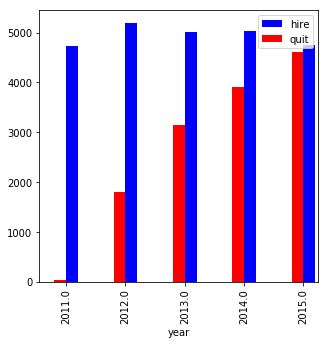

In [35]:

fig,ax = plt.subplots(figsize=(5,5),sharey=True)
params = {'width':0.2,'kind':'bar','legend':True}
df.groupby('join_date_year').size().plot(color='blue',position=0,label='hire',**params)
df.groupby('quit_date_year').size().plot(color='red',position=1,label='quit',**params)
ax.set_xlabel('year')


Number of hires per year are steady, but number of employees leaving is on the rise (trend)

Text(0.5,0,'day_of_week')

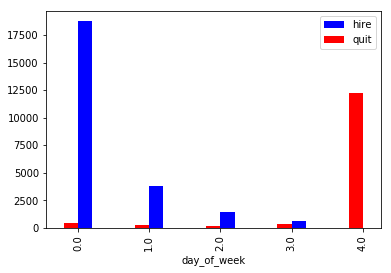

In [36]:
fig,ax = plt.subplots(sharey=True)
params = {'width':0.2,'kind':'bar','legend':True}
df.groupby('join_date_dayofweek').size().plot(color='blue',position=0,label='hire',**params)
df.groupby('quit_date_dayofweek').size().plot(color='red',position=1,label='quit',**params)
ax.set_xlabel('day_of_week')

It makes sense that majority of new hires come in on Monday, and Friday is their last day of work

## headcount table

In [13]:
df_headcount = get_headcount()

In [14]:
df_headcount.head()

,date,company_id,join_count,quit_count,headcount,date_year,date_month,date_day,date_dayofweek
0,2011-01-24,1,25,0,25,2011,1,24,0
1,2011-01-24,2,17,0,17,2011,1,24,0
2,2011-01-24,3,9,0,9,2011,1,24,0
3,2011-01-24,4,12,0,12,2011,1,24,0
4,2011-01-24,5,5,0,5,2011,1,24,0


In [ ]:
df_headcount